In [494]:
import time
import numpy as np
from scipy.integrate import odeint


def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [495]:
#print(t1-t0)

In [496]:
#r = odeint(vectors2, r0, t, args=(I, J))
#r = ode(f, jac).set_integrator('zvode', method='bdf').set_initial_value(r0, 0)

In [497]:
#r.set_initial_value(r0, 0)#.set_f_params(2.0).set_jac_params(2.0)

In [564]:
Gamma_ud=0.4
Gamma_du=0.2
Gamma_el=1.6


gammaplus=Gamma_du/2
gammaminus=Gamma_ud/2
gammaz=Gamma_el/8


Dissipation_factor=1


Gamma=np.array(Dissipation_factor*[gammaplus,gammaminus,gammaz])  #[gamma+,gamma-,gammaz]

In [565]:
rho_init0=np.array([[1/2,1/2],[1/2,1/2]])    #density matrix |+><+|


def trace(A):
    return np.trace(A)

def matmu(A,B):
    return np.matmul(A,B)

#rho_init1=np.array([[1,0],[0,0]])    #By default
#rho_init2=np.array([[1,0],[0,0]])    #By default




N=30




sigma_p= np.array([[0,1],[0,0]])
sigma_m= np.array([[0,0],[1,0]])
sigma_z= np.array([[1,0],[0,-1]])


##Initial values one operator

sp_init0=trace(matmu(rho_init0,sigma_p))
sz_init0=trace(matmu(rho_init0,sigma_z))
sm_init0=trace(matmu(rho_init0,sigma_m))

Genit=[sp_init0,sz_init0,sm_init0]


r0=[]
fact=int(N*(N-1)/2)

r0=[Genit[0]]*N+[Genit[1]]*N+[Genit[0]**2]*fact+[Genit[0]*Genit[2]]*fact+[Genit[0]*Genit[1]]*2*fact+[Genit[1]**2]*fact

In [566]:
#Random interaction matrix

A=np.random.rand(N,N)
A= np.triu(A)
np.fill_diagonal(A, 0)

In [567]:
#Homogeneous interaction matrix

Jef=1

A=np.ones((N,N))
A= np.triu(A)
np.fill_diagonal(A, 0)
A=Jef*A

In [568]:
def del_list(N):
    
    s=[]
    count=0
    for j in range (0,N):
        s.append((count)%N)
        count=count+1
    
    s_fin=s*(N) 

    count=0
    while count<len(s_fin):
        del(s_fin[count])
        count=count+N
    
    sfin=np.array(s_fin)
    
    return sfin

In [569]:
def new_indexer(N):
    s=[]
    for j in range(N):
        s=s+[j]*(N-1)
    return np.array(s)

In [570]:
def up_triang(N):
    ar = np.array(np.zeros((N,N)))
    indices = np.triu_indices_from(ar)
    indexer=[]
    for j in range(len(indices[0])):
        if indices[0][j]!=indices[1][j]:
            indexer.append([indices[0][j],indices[1][j]])
    return np.array(indexer)+N    

In [571]:
def index_p(Arr,ind):
    
    return np.array([i for i, e in enumerate(Arr) if e == ind])+int(2*N+N*(N-1))   #return the indexes required for dpdt

In [572]:
def computeIJ(N):
    i = np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)),dtype = 'complex_')
    r0=[]
    extern=np.zeros(int(N*(5*N-1)/2))
    
    
    Indexer=del_list(N)
    new_index=new_indexer(N)
    
    
    for j in range (0,N):  #dpdt
        i[j][j]=-(Gamma[0]+Gamma[1]+4*Gamma[2])
        for w in index_p(del_list(N),j):
            i[j][w]=2*1j*(A[j][new_index[w-int(2*N+N*(N-1))]]+A[new_index[w-int(2*N+N*(N-1))]][j])   #   
        
    for j in range (N,2*N): #dzdt
        i[j][j]=-2*(Gamma[0]+Gamma[1])
        extern[j]=2*(Gamma[0]-Gamma[1])

    for j in range (2*N,int(2*N+N*(N-1)/2)):  #dpadpbdt
        i[j][j]=-2*(Gamma[0]+Gamma[1]+4*Gamma[2])
    for j in range (int(2*N+N*(N-1)/2),int(2*N+N*(N-1))):  #dpadmbdt
        i[j][j]=-2*(Gamma[0]+Gamma[1]+4*Gamma[2])
    
    
    count=0
    for j in range (int(2*N+N*(N-1)),int(2*N+2*N*(N-1))):   #dzadpbdt
        i[j][j]=-2*(3*(Gamma[0]+Gamma[1])+4*Gamma[2])
        i[j][Indexer[count]]=2*(Gamma[0]-Gamma[1])+2*1j*(A[Indexer[count]][new_index[count]]+A[new_index[count]][Indexer[count]])   #I use Jef for now
        count=count+1
        
    
    count=0        
    for j in range (int(2*N+2*N*(N-1)),int(2*N+5*N*(N-1)/2)):   #dzadzbdt
        i[j][j]=-4*(Gamma[0]+Gamma[1]) 
        i[j][up_triang(N)[count][0]]=-2*(Gamma[1]-Gamma[0])
        i[j][up_triang(N)[count][1]]=-2*(Gamma[1]-Gamma[0])
        count=count+1
        
    return extern, i

In [573]:
def vectors2(r, t, extern, i):
    s = i @ r  #Vector multiplication
    drdt = s+extern
    
    
    
    
    
    
    
    return drdt

In [574]:
import time 

t0=time.time()
extern, i = computeIJ(N)

t = np.linspace(0, 20, 1000)

r = odeintz(vectors2, r0, t, args=(extern, i))


t1=time.time()

print(t1-t0)

37.88185000419617


C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


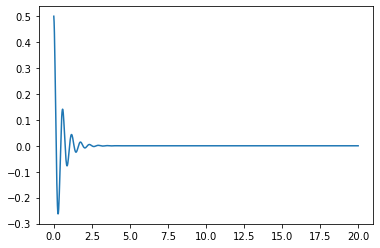

In [575]:
plt.plot(t,r[:,0])